In [2]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as smapi
import statsmodels.graphics as smgraphics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

/Users/vrotmanh/Documents/Cornell/Spring 2018/Spec/Anomaly/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load Linear Train Data
linear_data = []
linear_labels = []
with open('linear/train.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # To avoid bad data
        if row['x'] and row['y']:
            linear_data.append(float(row['x']))
            linear_labels.append(float(row['y']))

In [4]:
#Plot original data
def plot_data(data, labels):
    plt.plot(data, labels, 'bo')
    
#Plot anomalies
def plot_anomalies_data(data, labels, anomalies_data, anomalies_labels):
    plt.plot(anomalies_data, anomalies_labels, 'ro')
    plt.plot(data, labels, 'bo')
    plt.show()

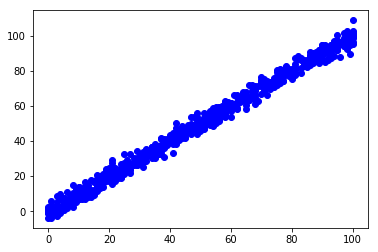

In [5]:
plot_data(linear_data, linear_labels)

In [6]:
#Generate random point
#def generate_random_point(min_val, max_val):
#   return random.uniform(min_val, max_val)

#Add random points to the data
def add_random_points(number, dataset, label):
    res_data = dataset
    res_label = label
    maxX = max(dataset)
    minX = min(dataset)
    maxY = max(label)
    minY = min(label)
    random_points_x = np.random.uniform(low=minX, high=maxX, size=(number,))
    random_points_y = np.random.uniform(low=minY, high=maxY, size=(number,))
    data = np.concatenate((np.array(res_data), np.array(random_points_x)), axis=0)
    labels = np.concatenate((np.array(res_label), np.array(random_points_y)), axis=0)
    return data, labels

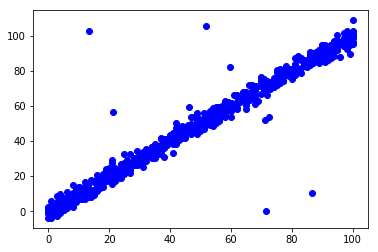

In [7]:
#Add random point to data
dataRand, labelsRand = add_random_points(10, linear_data, linear_labels)
plot_data(dataRand, labelsRand)

In [8]:
data2 = dataRand
labels2 = labelsRand

In [9]:
#Fit model using linear regression
def fit_linear_regression(data, labels):
    regr = linear_model.LinearRegression()
    regr.fit(data[:, np.newaxis], labels)
    predicted_labels = regr.predict(data[:, np.newaxis])
    s = mean_squared_error(labels, predicted_labels)
    return s, predicted_labels

In [10]:
s, predicted_labels = fit_linear_regression(data2, labels2)

/Users/vrotmanh/Documents/Cornell/Spring 2018/Spec/Anomaly/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [11]:
#Calculate cooks distance
def get_cooks_distance(data, labels):
    fitted = smapi.OLS(data2, labels2).fit()
    influence = fitted.get_influence()
    #c is the distance and p is p-value
    (c, p) = influence.cooks_distance
    plt.stem(np.arange(len(c)), c, markerfmt=",")
    return c

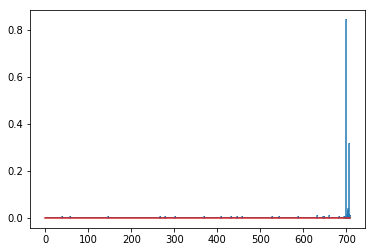

In [12]:
distance = get_cooks_distance(data2, labels2)

In [13]:
def detect_anomalies(data, labels, distance, predicted_labels):
    anomalies = {}
    anomalies_diff = {}
    for i in range(len(data)):
        diff = abs(labels[i] - predicted_labels[i])
        dist_mod = distance
        
#         print('initial: ',distance[i])
        
        if distance[i] < 1:
#             print('less than one')
            string = str(distance[i])
#             print('str: ',string)
            if string.find('-') != -1:
                d = int(string.partition('-')[2])
#                 print('power: ',d)
                dist_mod[i] = distance[i]*(10**d)
            else:
                point_part = str(int(string.partition('.')[2]))
                len_diff = len(string) - len(point_part) - 1
#                 print('power: ',len_diff)
                dist_mod[i] = distance[i]*(10**len_diff)
        
#         print('diff: ',diff)
#         print('dist: ',dist_mod[i])
        
        if diff > dist_mod[i]:
            anomalies[i] = True
            anomalies_diff[i] = int(round(diff - dist_mod[i]))
        else:
            anomalies[i] = False
            
    return anomalies, anomalies_diff

In [14]:
anomalies, anomalies_diff = detect_anomalies(data2, labels2, distance, predicted_labels)

In [15]:
trueA = list(anomalies.values())
print(trueA.count(True))

215


In [16]:
anomalies_diff

In [16]:
from collections import Counter

def get_least_frequent(anomalies,anomalies_diff):
    lst = list(anomalies_diff.values())
    cnt = Counter(lst)
#     mincnt = min(cnt.values())
#     minval = next(n for n in reversed(lst) if cnt[n] == mincnt)
    
    return int(np.mean(list(cnt.values())))

In [17]:
threshold = get_least_frequent(anomalies,anomalies_diff)

In [18]:
data3 = []
labels3 = []
anomalies_data = []
anomalies_labels = []

for i in range(len(data2)):
    if anomalies[i] == True:
        if anomalies_diff[i] > threshold:
            anomalies_data.append(data2[i])
            anomalies_labels.append(labels2[i])
        else: 
            data3.append(data2[i])
            labels3.append(labels2[i])
    elif anomalies[i] == False:
        data3.append(data2[i])
        labels3.append(labels2[i])

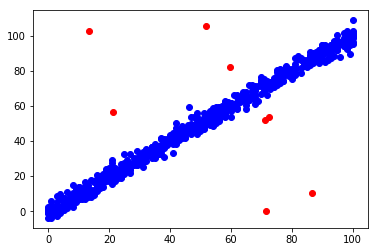

In [19]:
plot_anomalies_data(data3, labels3, anomalies_data, anomalies_labels)

In [49]:
from scipy.interpolate import spline

def anomaly_border(data3, labels3, anomalies_data, anomalies_labels, data2, label_mod):   
    plt.plot(anomalies_data, anomalies_labels, 'ro')
    plt.plot(data3, labels3, 'bo')
    
    top_border = []
    bottom_border = []
    for i in range(len(data3)):
        top_border.append(predicted_labels[i] + threshold)
        bottom_border.append(predicted_labels[i] - threshold)
        
    plt.plot(data3, top_border, 'go')
    plt.plot(data3, bottom_border, 'go')
    
    #xnew = np.linspace(min(data2),max(data2),len(data2))
    #label_smooth = spline(data2,label_mod,xnew)
    #plt.plot(xnew,label_smooth)
    
    plt.show()

In [50]:
label_mod = []
for i in range(len(labels2)):
    label_mod.append(labels2[i]+threshold)

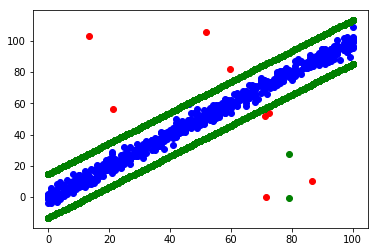

In [51]:
anomaly_border(data3, labels3, anomalies_data, anomalies_labels, data2, label_mod)